# Biodiversity in National Parks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from IPython.core.display import HTML
from scipy.stats import chi2_contingency

#Import the data

observations = pd.read_csv('observations.csv')

species = pd.read_csv('species_info.csv')

print("First dataset 'observations'.")
print(observations.head())

print()
print("Second dataset 'species'.")
print(species.head())

First dataset 'observations'.
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85

Second dataset 'species'.
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, B

#### The columns of the datasets are as follows:

### species

The `species_info.csv` has information on the different species in the National Parks. The columns in this data set are:
- **category** - The category for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The conservation status of the species


### observations

The `observations.csv` has information on the different species in the National Parks. The columns in this data set are:
- **scientific_name** - The scientific name of each species
- **park_name** - The name of the National Park
- **observations** - The number of observations in that park for the species in the past week


### **Things We Want to Answer**

The questions we want to answer are:
- Which category of species have the greatest amount in each category of conservation status?
- Which category of species has the highest percentage of species in conservation?
- Is there a significant difference between the number of species in conservation per category?
- Which endangered species have the lowest observation counts within the last 7 days?

In [6]:
#Gathering info about the dataframes

print(observations.info())
print(observations.describe())

print()
print()

print(species.info())
print(species.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None
       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usa

In [7]:
#The unique categories
print(species['category'].unique())

#Fill in the NaN values of conservation_status with no danger status
species_fixed = species.fillna(value = {"conservation_status": "No Danger Status"})

#All unique values for conservation_status
status_lst = species_fixed['conservation_status'].unique()
print(status_lst)

#Print all unique National Parks
print(observations['park_name'].unique())

print()
#Check for duplicates in the species dataframe!
species_fixed[species_fixed.duplicated(subset = ['scientific_name', "conservation_status"])]
species_fixed.duplicated(subset = ['scientific_name', "conservation_status"]).value_counts()

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
['No Danger Status' 'Species of Concern' 'Endangered' 'Threatened'
 'In Recovery']
['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']



False    5543
True      281
Name: count, dtype: int64

### There are 281 duplicates in the species DataFrame that have the same scientific name and same conservation status. Let's get rid of the duplicates in this DataFrame as to avoid statistical errors.

In [9]:
species_fixed = species_fixed.drop_duplicates(subset = ['scientific_name', "conservation_status"])
print(len(species_fixed))
print(species_fixed.head())

5543
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole    No Danger Status  
1                              American Bison, Bison    No Danger Status  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...    No Danger Status  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)    No Danger Status  
4                                      Wapiti Or Elk    No Danger Status  


In [10]:
print('The makeup of each catgeory:')
print(species_fixed['category'].value_counts())

print()

print('How many of each type of conservation_status we have for each category.')
#Making a new dataframe containing the counts for each conservation_status based on category of species
conservation_df = species_fixed[['category', 'conservation_status', 'common_names']].groupby(['category', 'conservation_status']).count().reset_index()

#Changing the column name of common_names to counts
conservation_df.rename(columns={"common_names": "counts"}, inplace=True)
print(conservation_df)

The makeup of each catgeory:
category
Vascular Plant       4262
Bird                  488
Nonvascular Plant     333
Mammal                177
Fish                  126
Amphibian              79
Reptile                78
Name: count, dtype: int64

How many of each type of conservation_status we have for each category.
             category conservation_status  counts
0           Amphibian          Endangered       1
1           Amphibian    No Danger Status      72
2           Amphibian  Species of Concern       4
3           Amphibian          Threatened       2
4                Bird          Endangered       4
5                Bird         In Recovery       3
6                Bird    No Danger Status     413
7                Bird  Species of Concern      68
8                Fish          Endangered       3
9                Fish    No Danger Status     115
10               Fish  Species of Concern       4
11               Fish          Threatened       4
12             Mammal          

## Let's graph some of the counts for the different conservation statuses

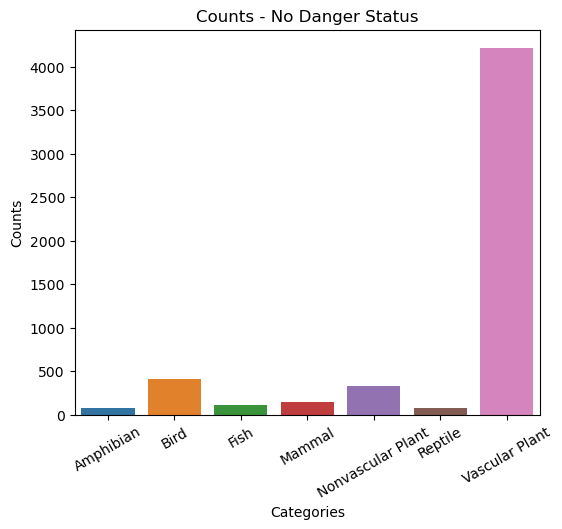

<Figure size 640x480 with 0 Axes>

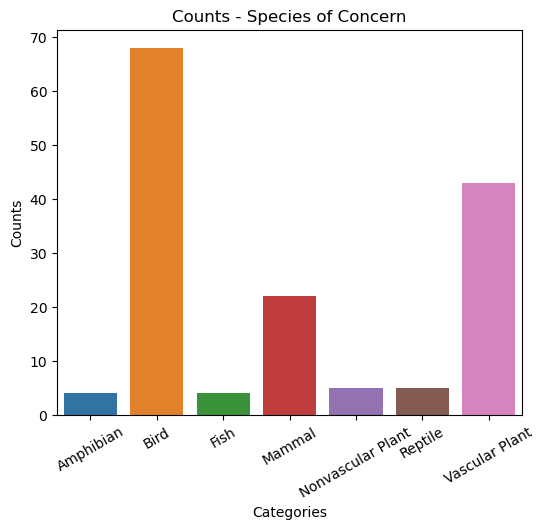

<Figure size 640x480 with 0 Axes>

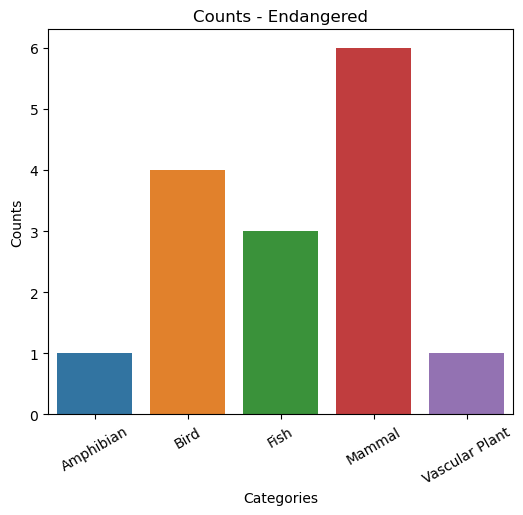

<Figure size 640x480 with 0 Axes>

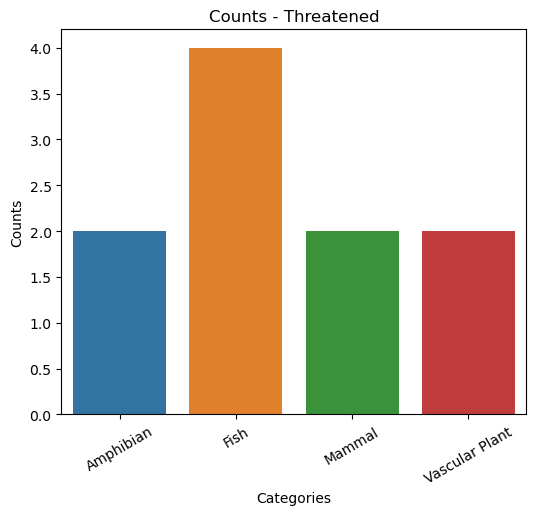

<Figure size 640x480 with 0 Axes>

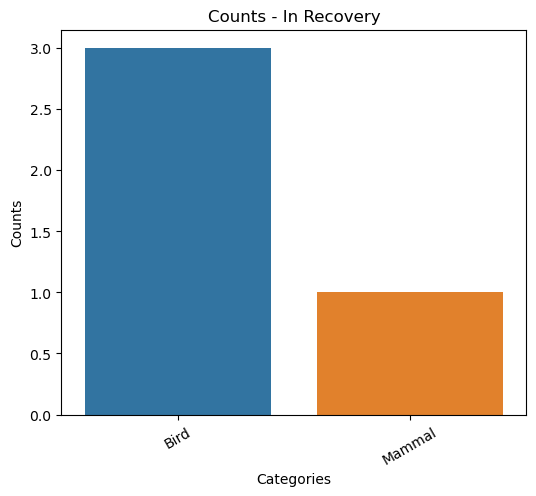

<Figure size 640x480 with 0 Axes>

In [160]:
#Graphs all the statuses with bar graphs
for item in status_lst:   
    plt.figure(figsize = (6, 5))
    #Creating a name for the file of each graph
    fig_name = item.replace(" ", "_") + "_bar.png"
    fig_name = fig_name.lower()
    
    sns.barplot(data = conservation_df[conservation_df['conservation_status'] == item], x = 'category', y = 'counts', hue = 'category')
    plt.title("Counts - " + str(item))
    plt.xticks(rotation=30)
    plt.xlabel("Categories")
    plt.ylabel('Counts')
    plt.savefig(fig_name, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    print()

In [37]:
print(species_fixed[(species_fixed['conservation_status'] == "In Recovery") & (species_fixed['category'] == 'Mammal')])

print()

print(species_fixed[(species_fixed['conservation_status'] == "In Recovery") & (species_fixed['category'] == 'Bird')])

print()

print(species_fixed[(species_fixed['conservation_status'] == "Threatened") & (species_fixed['category'] == 'Fish')])

print()

print("The birds have the highest amount of species of concern with {}, whereas the second highest is vascular plants with {}".format(len(species_fixed[(species_fixed['conservation_status'] == "Species of Concern") & (species_fixed['category'] == 'Bird')]), len(species_fixed[(species_fixed['conservation_status'] == "Species of Concern") & (species_fixed['category'] == 'Vascular Plant')])))

print()
print()

print("Vascular plants have {} with no danger status, whereas the second highest count of no danger status is the birds with {}".format(len(species_fixed[(species_fixed['conservation_status'] == "No Danger Status") & (species_fixed['category'] == 'Vascular Plant')]), len(species_fixed[(species_fixed['conservation_status'] == "No Danger Status") & (species_fixed['category'] == 'Bird')])))

     category scientific_name     common_names conservation_status
3020   Mammal     Canis lupus  Gray Wolf, Wolf         In Recovery

     category           scientific_name               common_names  \
100      Bird  Haliaeetus leucocephalus                 Bald Eagle   
3143     Bird   Falco peregrinus anatum  American Peregrine Falcon   
4565     Bird    Pelecanus occidentalis              Brown Pelican   

     conservation_status  
100          In Recovery  
3143         In Recovery  
4565         In Recovery  

     category                scientific_name              common_names  \
490      Fish              Erimonax monachus              Spotfin Chub   
571      Fish            Noturus flavipinnis          Yellowfin Madtom   
3283     Fish            Oncorhynchus mykiss             Rainbow Trout   
4612     Fish  Oncorhynchus clarkii henshawi  Lahontan Cutthroat Trout   

     conservation_status  
490           Threatened  
571           Threatened  
3283          Threatene

#### We can see that the only 2 categories in recovery are birds and mammals. The only mammal in recovery is the wolf/gray wolf, and the 3 birds are the Bald Eagle, American Peregrine Falcon, and the Brown Pelican.

#### Also interesting is the fact that the category with the most amount of threatened species are the fish with 4. There is a 3 way tie for second highest in this category between amphibians, mammals, and vascular plants, which they all have 2.

#### Mammals have the most endangered species with 6 while birds have the second most with 4.

#### Birds have the most species of concern with 68 while vascular plants have the second highest with 43!

#### When looking at categories with no danger status, vascular plants have the most with 4,216! The second highest are birds with 413.

## What categories have the most under conservation as opposed to not?

In [173]:
#Make a dataframe that has each category with the count of not in conservation as a column, in conservation in a column, 
# and the ratio/percent in a third column
category_lst = species_fixed['category'].unique()

#Saves the amount with no conservation status and in conservation for all categories
mammals_no = conservation_df[(conservation_df['category'] == 'Mammal') & (conservation_df['conservation_status'] == 'No Danger Status')]
mammals_no = mammals_no.counts.sum()

mammals_yes = conservation_df[(conservation_df['category'] == 'Mammal') & (conservation_df['conservation_status'] != 'No Danger Status')]
mammals_yes = mammals_yes.counts.sum()


birds_no = conservation_df[(conservation_df['category'] == 'Bird') & (conservation_df['conservation_status'] == 'No Danger Status')]
birds_no = birds_no.counts.sum()

birds_yes = conservation_df[(conservation_df['category'] == 'Bird') & (conservation_df['conservation_status'] != 'No Danger Status')]
birds_yes = birds_yes.counts.sum()

reptiles_no = conservation_df[(conservation_df['category'] == 'Reptile') & (conservation_df['conservation_status'] == 'No Danger Status')]
reptiles_no = reptiles_no.counts.sum()

reptiles_yes = conservation_df[(conservation_df['category'] == 'Reptile') & (conservation_df['conservation_status'] != 'No Danger Status')]
reptiles_yes = reptiles_yes.counts.sum()

amphibians_no = conservation_df[(conservation_df['category'] == 'Amphibian') & (conservation_df['conservation_status'] == 'No Danger Status')]
amphibians_no = amphibians_no.counts.sum()

amphibians_yes = conservation_df[(conservation_df['category'] == 'Amphibian') & (conservation_df['conservation_status'] != 'No Danger Status')]
amphibians_yes = amphibians_yes.counts.sum()

fish_no = conservation_df[(conservation_df['category'] == 'Fish') & (conservation_df['conservation_status'] == 'No Danger Status')]
fish_no = fish_no.counts.sum()

fish_yes = conservation_df[(conservation_df['category'] == 'Fish') & (conservation_df['conservation_status'] != 'No Danger Status')]
fish_yes = fish_yes.counts.sum()


vascular_no = conservation_df[(conservation_df['category'] == 'Vascular Plant') & (conservation_df['conservation_status'] == 'No Danger Status')]
vascular_no = vascular_no.counts.sum()

vascular_yes = conservation_df[(conservation_df['category'] == 'Vascular Plant') & (conservation_df['conservation_status'] != 'No Danger Status')]
vascular_yes = vascular_yes.counts.sum()


nonvascular_no = conservation_df[(conservation_df['category'] == 'Nonvascular Plant') & (conservation_df['conservation_status'] == 'No Danger Status')]
nonvascular_no = nonvascular_no.counts.sum()

nonvascular_yes = conservation_df[(conservation_df['category'] == 'Nonvascular Plant') & (conservation_df['conservation_status'] != 'No Danger Status')]
nonvascular_yes = nonvascular_yes.counts.sum()


no_lst = [mammals_no, birds_no, reptiles_no, amphibians_no, fish_no, vascular_no, nonvascular_no]
yes_lst = [mammals_yes, birds_yes, reptiles_yes, amphibians_yes, fish_yes, vascular_yes, nonvascular_yes]

#Use a for loop to figure out the percent of species in conservation for all categories
perc_conservation = []
for i in range(len(no_lst)):
    current = (yes_lst[i]/(yes_lst[i]+no_lst[i])*100)
    perc_conservation.append(current)

# initialize data of lists.
data = {'Category': category_lst,
        'Not in Conservation': no_lst,
        'In Conservation': yes_lst,
        'Percent in Conservation': perc_conservation}


percent_df = pd.DataFrame(data)


print()
print(percent_df.sort_values('Percent in Conservation', ascending = False))


            Category  Not in Conservation  In Conservation  \
0             Mammal                  146               31   
1               Bird                  413               75   
3          Amphibian                   72                7   
4               Fish                  115               11   
2            Reptile                   73                5   
6  Nonvascular Plant                  328                5   
5     Vascular Plant                 4216               46   

   Percent in Conservation  
0                17.514124  
1                15.368852  
3                 8.860759  
4                 8.730159  
2                 6.410256  
6                 1.501502  
5                 1.079305  


In [175]:
#Make it look fancy
display(HTML(percent_df.sort_values('Percent in Conservation', ascending = False).to_html(index=False)))

Category,Not in Conservation,In Conservation,Percent in Conservation
Mammal,146,31,17.514124
Bird,413,75,15.368852
Amphibian,72,7,8.860759
Fish,115,11,8.730159
Reptile,73,5,6.410256
Nonvascular Plant,328,5,1.501502
Vascular Plant,4216,46,1.079305


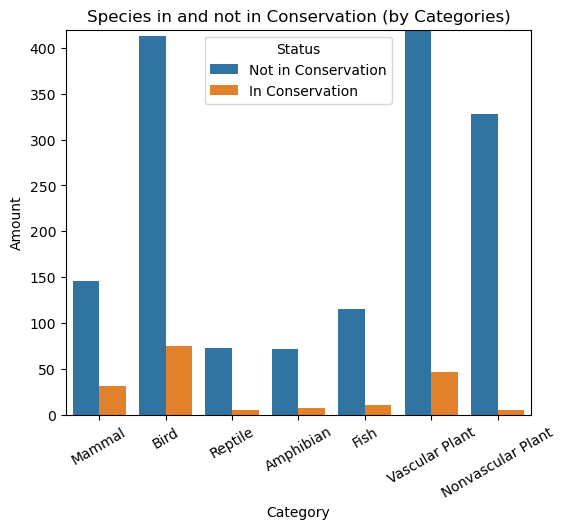

In [168]:
#Reshaping dataframe so it is easier to graph
percent_graph = pd.melt(frame = percent_df, id_vars = 'Category', value_vars = ["Not in Conservation", "In Conservation"], value_name = "Amount", var_name = 'Status')

plt.figure(figsize=(6, 5))

sns.barplot(data = percent_graph, x = 'Category', y="Amount", hue = 'Status')
plt.xticks(rotation = 30)
plt.ylim(0, 420)
plt.title("Species in and not in Conservation (by Categories)")
plt.savefig('conservation_side_bar.png', bbox_inches = 'tight')
plt.show()


## Is there a significant difference between the amount of species in conservation per category?

 We know that in the context of chi-square, the null hypothesis assumes no significant difference exists between the categories’ observed and expected frequencies. Any difference seen is likely due to chance or some random error rather than a meaningful statistical difference. We want to see if there are statistically significant differences in conservation status rates based on different categories of species. We will do this with a significance value of 0.05

 Since Mammals and Birds have the highest percent in conservation, let's look at those first:

In [124]:
table_1 = [[146, 31], [413, 75]]

res = chi2_contingency(table_1)

print("The P-Value we get is {}, which is greater than our 0.05 significance value, thus there is not sufficient evidence at the 0.05 significance level to support that there is a significant difference between the two.".format(res.pvalue))
print()
print()
print(chi2_contingency(table_1))

The P-Value we get is 0.583638782116612, which is greater than our 0.05 significance value, thus there is not sufficient evidence at the 0.05 significance level to support that there is a significant difference between the two.


Chi2ContingencyResult(statistic=0.3003887977788037, pvalue=0.583638782116612, dof=1, expected_freq=array([[148.78646617,  28.21353383],
       [410.21353383,  77.78646617]]))


Now let's try the same thing for mammals and reptiles:

In [91]:
table_2 = [[146, 31], [73, 5]]

res = chi2_contingency(table_2)
print("The P-Value for this test is {}, which is smaller than 0.05! Thus, there is a significant difference between mammals and reptiles!".format(res.pvalue))
print()
print("Looking at the results of our dataset with this given information, we can see that mammals have a statistically significant higher rate of needing protection through conservation compared to reptiles.")

print()
print()
print(chi2_contingency(table_2))

The P-Value for this test is 0.03145537265429932, which is smaller than 0.05! Thus, there is a significant difference between mammals and reptiles!

Looking at the results of our dataset with this given information, we can see that mammals have a statistically significant higher rate of needing protection through conservation compared to reptiles.


Chi2ContingencyResult(statistic=4.627936545853599, pvalue=0.03145537265429932, dof=1, expected_freq=array([[152.01176471,  24.98823529],
       [ 66.98823529,  11.01176471]]))


Now let's try the same thing for mammals and fish:

In [170]:
table_3 = [[146, 31], [115, 11]]

res = chi2_contingency(table_3)

print("The P-Value we get is {}, which is less than our 0.05 significance value, thus there is a significant difference between the two categories: mammals and fish.".format(res.pvalue))

print("Looking at the results of our dataset with this given information, we can see that mammals have a statistically significant higher rate of needing protection through conservation compared to fish.")
print()
print()
print(chi2_contingency(table_3))

The P-Value we get is 0.04419316083816412, which is less than our 0.05 significance value, thus there is a significant difference between the two categories: mammals and fish.
Looking at the results of our dataset with this given information, we can see that mammals have a statistically significant higher rate of needing protection through conservation compared to fish.


Chi2ContingencyResult(statistic=4.04916646345531, pvalue=0.04419316083816412, dof=1, expected_freq=array([[152.46534653,  24.53465347],
       [108.53465347,  17.46534653]]))


## Which Endangered species has the lowest observation counts within the last 7 days?

In [63]:
print(species_fixed[species_fixed["conservation_status"] == "Endangered"].reset_index(drop=True))

endangered_df = species_fixed[species_fixed["conservation_status"] == "Endangered"].reset_index(drop=True)
scientific_names = []
common_names = []
category = []

#Iterates through the scientific names, categories, and common names that are endangered and saves them to a list.
for i in range(len(endangered_df)):
    scientific_names.append(endangered_df.at[i, 'scientific_name'])
    common_names.append(endangered_df.at[i, 'common_names'])
    category.append(endangered_df.at[i, 'category'])

#print(scientific_names)
#print(common_names)
#print(category)

          category               scientific_name  \
0           Mammal                   Canis lupus   
1           Mammal                   Canis rufus   
2           Mammal             Myotis grisescens   
3           Mammal                Myotis sodalis   
4           Mammal  Glaucomys sabrinus coloratus   
5             Bird                Grus americana   
6             Bird           Vermivora bachmanii   
7             Bird             Picoides borealis   
8             Fish          Etheostoma percnurum   
9             Fish               Noturus baileyi   
10  Vascular Plant                 Geum radiatum   
11            Fish             Chasmistes liorus   
12          Mammal       Ovis canadensis sierrae   
13            Bird       Gymnogyps californianus   
14       Amphibian                  Rana sierrae   

                                         common_names conservation_status  
0                                           Gray Wolf          Endangered  
1              

In [71]:
observation_count = []

#Finds all the counts for each species observation
for name in scientific_names:
    #df containing all rows with the scientific name
    name_df = observations[observations["scientific_name"] == name]
    observation_count.append(name_df['observations'].sum())

#print(observation_count)

# initialize data of lists.
data = {'Category': category,
        'Scientific Name': scientific_names,
        'Common Name': common_names,
        'Observations (past 7 days)': observation_count}


observation_count = pd.DataFrame(data)

#Sorts the dataframe so it goes from most observed to least
observation_count = observation_count.sort_values('Observations (past 7 days)', ascending = False).reset_index(drop = True)


#Make it look fancy
print("Observations of Endangered Species within the last 7 days:")
display(HTML(observation_count.to_html(index=False)))

Observations of Endangered Species within the last 7 days:


Category,Scientific Name,Common Name,Observations (past 7 days)
Mammal,Canis lupus,Gray Wolf,715
Fish,Etheostoma percnurum,Duskytail Darter,166
Vascular Plant,Geum radiatum,"Mountain Avens, Spreading Avens",162
Mammal,Myotis grisescens,Gray Myotis,160
Bird,Gymnogyps californianus,California Condor,156
Mammal,Glaucomys sabrinus coloratus,"Carolina Northern Flying Squirrel, Northern Flying Squirrel",153
Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,153
Bird,Picoides borealis,Red-Cockaded Woodpecker,146
Fish,Chasmistes liorus,June Sucker,146
Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",145


As we can see, the bottom 3 are birds and mammals. From our chi-square tests above, we concluded that mammals' conservation status relationship is significantly different to both fish and reptiles.

The National Parks thus should keep a very close watch on mammals and birds in particular, such as the Red Wolf and Whooping Crane.

## Let's Check to see how many of these two species are in each park:

      Scientific Name                            park_name  observations
939       Canis rufus                  Bryce National Park            30
3855      Canis rufus               Yosemite National Park            34
9753   Grus americana  Great Smoky Mountains National Park            13
10848  Grus americana            Yellowstone National Park            57
13745  Grus americana                  Bryce National Park            24
15906     Canis rufus  Great Smoky Mountains National Park            13
15940     Canis rufus            Yellowstone National Park            60
20342  Grus americana               Yosemite National Park            37


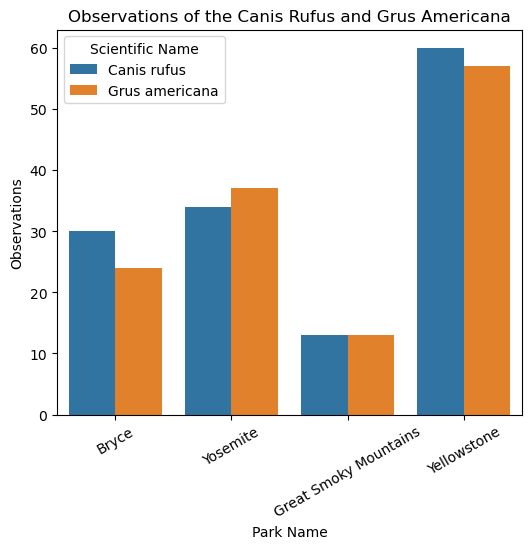

In [241]:
whooping_wolf = observations[(observations["scientific_name"] == "Canis rufus") | (observations["scientific_name"] == "Grus americana")]

#Renaming the column to look better
whooping_wolf = whooping_wolf.rename(columns = {"scientific_name": "Scientific Name"})

print(whooping_wolf)
whooping_wolf.park_name = whooping_wolf['park_name'].replace(" National Park", "", regex = True)


plt.figure(figsize = (6, 5))
sns.barplot(data = whooping_wolf, x = "park_name", y = "observations", hue = "Scientific Name")
plt.xlabel("Park Name")
plt.ylabel("Observations")
plt.title("Observations of the Canis Rufus and Grus Americana")
plt.xticks(rotation = 30)
plt.savefig("whooping_wolf.png", bbox_inches = 'tight')
plt.show()

## **Conclusions:**

- Which category of species have the greatest amount in each category of conservation status?
  - The 2 categories in recovery are birds and mammals. The only mammal in recovery is the wolf/gray wolf, and the 3 birds are the Bald Eagle, American Peregrine Falcon, and the Brown Pelican.
  - The category with the most amount of threatened species are the fish with 4. There is a 3 way tie for second highest in this category between amphibians, mammals, and vascular plants, which they all have 2.
  - Mammals have the most endangered species with 6 while birds have the second most with 4.
  - Birds have the most species of concern with 68 while vascular plants have the second highest with 43!
  - When looking at categories with no danger status, vascular plants have the most with 4,216! The second highest is the birds with 413.

--------------------------------------------------------------------------------------------------------------------------------------------------------
- Which category of species has the highest percentage of species in conservation?
    - Mammals with 17.514% Second is Birds with 15.369%
--------------------------------------------------------------------------------------------------------------------------------------------------------
- Is there a significant difference between the amount of species in conservation per category?
    - There is a significant difference between mammals and reptiles, as well as mammals and fish when looking at their relationship of conservation status.
--------------------------------------------------------------------------------------------------------------------------------------------------------
- Which endangered species have the lowest observation counts within the last 7 days (bottom 5)?
    - 5) Sierra Nevada Yellow-Legged Frog
    - 4) Smoky Madtom
    - 3) Bachman's Warbler, Bachman's Wood Warbler
    - 2) Red Wolf
    - 1) Whooping Crane